# Punctuation Restoration for Mental Health Conversations

**Assignment Goal**: Build a punctuation restoration system using domain-specific mental health conversations

**Approach**: Sequence-to-Sequence (Seq2Seq) with T5 Transformer


**Dataset**: [NLP Mental Health Conversations](https://www.kaggle.com/datasets/thedevastator/nlp-mental-health-conversations/data)

## 1. Setup & Installation

In [1]:
# Install required packages
!pip install -q transformers datasets torch accelerate kaggle pandas numpy matplotlib seaborn scikit-learn nltk evaluate sentencepiece rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [2]:
# Import libraries
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize, word_tokenize

# Transformers
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14,6)

print("✅ All libraries imported!")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🤗 Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ All libraries imported!
🔥 PyTorch: 2.9.0+cu126
🤗 Device: cuda


## 2. Dataset Acquisition

In [3]:
# Upload Kaggle credentials
from google.colab import files
print("📤 Upload kaggle.json:")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d thedevastator/nlp-mental-health-conversations
!unzip -q nlp-mental-health-conversations.zip

print("✅ Dataset downloaded!")

📤 Upload kaggle.json:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/thedevastator/nlp-mental-health-conversations
License(s): CC0-1.0
  0% 0.00/1.48M [00:00<?, ?B/s]
100% 1.48M/1.48M [00:00<00:00, 256MB/s]
✅ Dataset downloaded!


## 3. Dataset Loading & Understanding

In [4]:
# Load dataset
df = pd.read_csv('train.csv')

print("📊 Dataset Shape:", df.shape)
print("\n📋 Columns:", df.columns.tolist())
print("\n🔍 Info:")
print(df.info())
print("\n📈 Stats:")
print(df.describe())
print("\n❌ Missing Values:")
print(df.isnull().sum())

📊 Dataset Shape: (3512, 2)

📋 Columns: ['Context', 'Response']

🔍 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB
None

📈 Stats:
                                                  Context  \
count                                                3512   
unique                                                995   
top     I have so many issues to address. I have a his...   
freq                                                   94   

                                                 Response  
count                                                3508  
unique                                               2479  
top     If you have only been to a couple of sessions,...  
freq                                                    3  

❌ Missi

##4. Data Preprocessing & Quality Analysis

In [5]:
# Extract Response column
response_col = 'Response' if 'Response' in df.columns else df.columns[-1]
texts = df[response_col].dropna().astype(str).tolist()

print(f"📊 Total responses: {len(texts)}")
print(f"📊 Unique responses: {len(set(texts))}")
print(f"📊 Duplicates: {len(texts) - len(set(texts))}")

# Remove duplicates
texts = list(set(texts))

# Filter out very short texts
texts = [t for t in texts if len(t.strip()) > 30]
print(f"\n📊 After cleaning: {len(texts)} unique responses")

# Sample for faster development
print(f"\n📝 Sample response:")
print(texts[0][:300], "...")

📊 Total responses: 3508
📊 Unique responses: 2479
📊 Duplicates: 1029

📊 After cleaning: 2475 unique responses

📝 Sample response:
How you you expressed your regret and taken responsibility for the pain thus far? Repair is a very essential skill in and part of developing healthy relationships. Your love sounds deep, sit with that. Also sit with how she's been hurt. You get to feel your hurt too and your kids. In feeling all thi ...


## 5. Comprehensive EDA

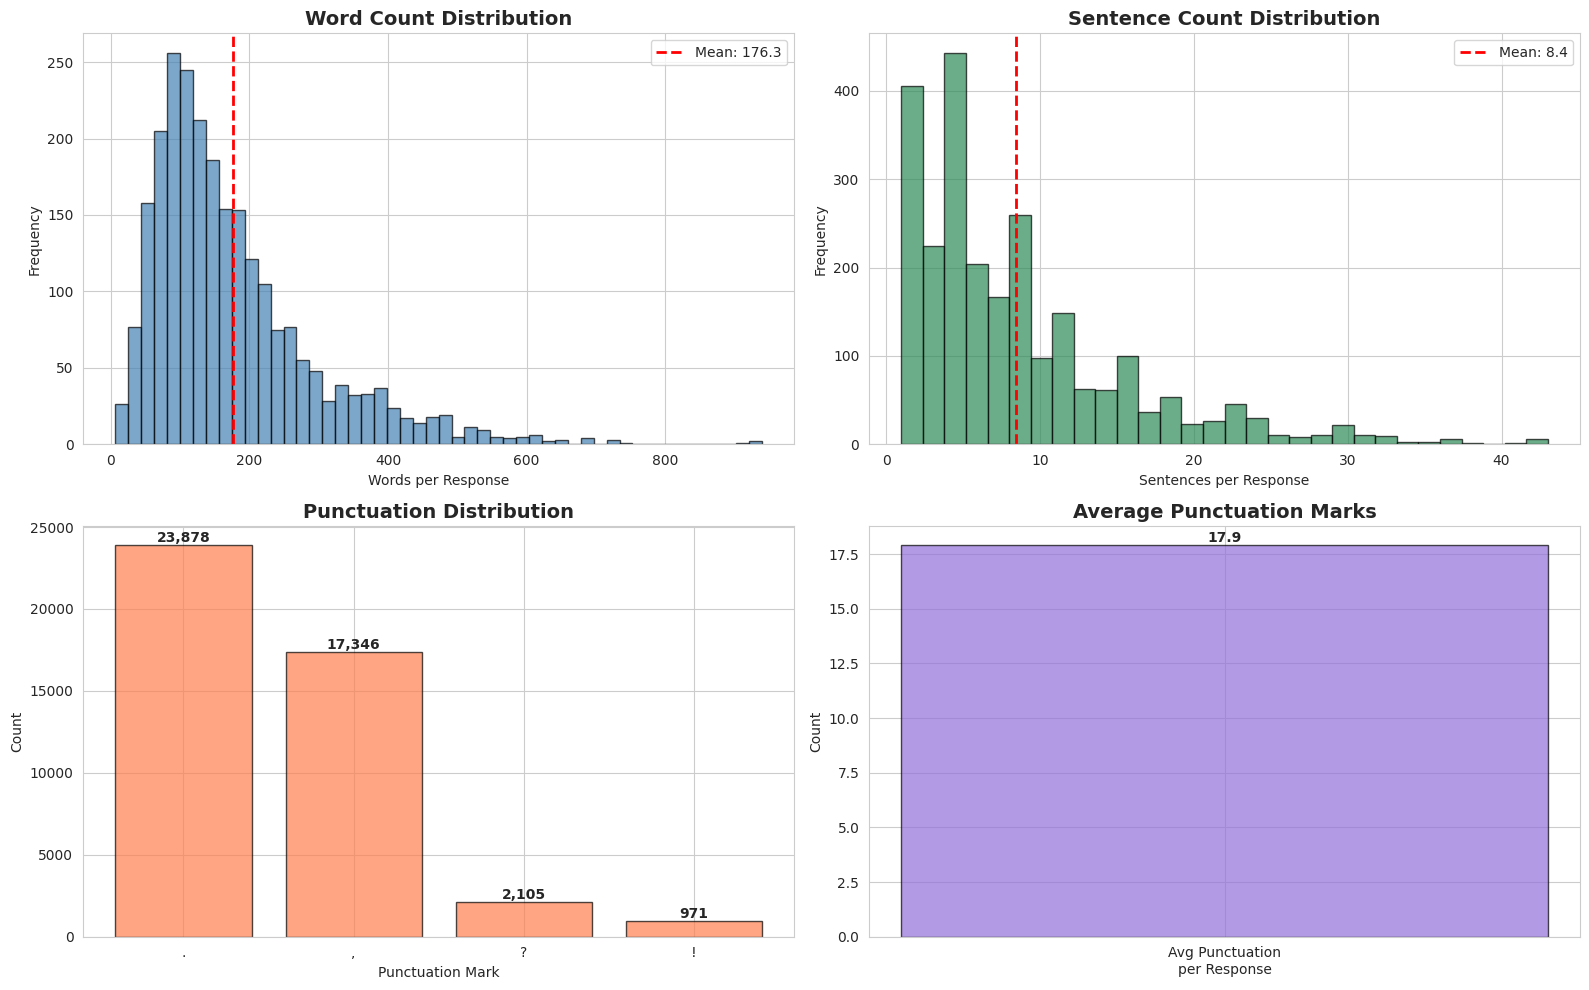


📊 Dataset Statistics:
  • Total responses: 2,475
  • Avg words/response: 176.3
  • Avg sentences/response: 8.4
  • Total punctuation: 44,300

📌 Punctuation Breakdown:
  • '.': 23,878 (53.9%)
  • ',': 17,346 (39.2%)
  • '?': 2,105 (4.8%)
  • '!': 971 (2.2%)


In [6]:
# Text analysis
word_counts = [len(t.split()) for t in texts]
sent_counts = [len(sent_tokenize(t)) for t in texts]

# Punctuation analysis
punct_stats = {'.': 0, ',': 0, '?': 0, '!': 0}
for text in texts:
    for p in punct_stats.keys():
        punct_stats[p] += text.count(p)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Word count distribution
axes[0,0].hist(word_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0,0].axvline(np.mean(word_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(word_counts):.1f}')
axes[0,0].set_title('Word Count Distribution', fontsize=14, weight='bold')
axes[0,0].set_xlabel('Words per Response')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Sentence count distribution
axes[0,1].hist(sent_counts, bins=30, edgecolor='black', alpha=0.7, color='seagreen')
axes[0,1].axvline(np.mean(sent_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sent_counts):.1f}')
axes[0,1].set_title('Sentence Count Distribution', fontsize=14, weight='bold')
axes[0,1].set_xlabel('Sentences per Response')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Punctuation distribution
axes[1,0].bar(punct_stats.keys(), punct_stats.values(), edgecolor='black', alpha=0.7, color='coral')
axes[1,0].set_title('Punctuation Distribution', fontsize=14, weight='bold')
axes[1,0].set_xlabel('Punctuation Mark')
axes[1,0].set_ylabel('Count')
for i, (k, v) in enumerate(punct_stats.items()):
    axes[1,0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Punctuation per response
total_punct = sum(punct_stats.values())
punct_per_response = total_punct / len(texts)
axes[1,1].bar(['Avg Punctuation\nper Response'], [punct_per_response], edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1,1].set_title('Average Punctuation Marks', fontsize=14, weight='bold')
axes[1,1].set_ylabel('Count')
axes[1,1].text(0, punct_per_response, f'{punct_per_response:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Dataset Statistics:")
print(f"  • Total responses: {len(texts):,}")
print(f"  • Avg words/response: {np.mean(word_counts):.1f}")
print(f"  • Avg sentences/response: {np.mean(sent_counts):.1f}")
print(f"  • Total punctuation: {total_punct:,}")
print(f"\n📌 Punctuation Breakdown:")
for k, v in punct_stats.items():
    pct = (v/total_punct)*100
    print(f"  • '{k}': {v:,} ({pct:.1f}%)")

## 6. Sentence-Level Dataset Creation

**Key Improvement**: Split into sentences to avoid truncation and create balanced examples

In [7]:
def create_sentence_dataset(texts, max_sentences=10000):
    sentences = []

    # Extract all sentences
    for text in texts:
        sents = sent_tokenize(text)
        sentences.extend(sents)
        if len(sentences) >= max_sentences:
            break

    sentences = sentences[:max_sentences]

    # Create input-output pairs
    dataset = []
    for sent in sentences:
        if len(sent.split()) < 3:
            continue

        input_text = re.sub(r'[.!?,;:]', '', sent)
        input_text = ' '.join(input_text.split())  # Clean extra spaces

        output_text = sent.strip()

        if input_text and output_text and input_text != output_text:
            dataset.append({
                'input': input_text.lower(),
                'output': output_text.lower()
            })

    return dataset

# Create dataset
print("=== Creating sentence-level dataset... ===")
dataset = create_sentence_dataset(texts, max_sentences=8000)

print(f"\n✅ Created {len(dataset):,} sentence pairs")
print(f"\n📝 Examples:")
for i in range(3):
    print(f"\n  Input:  {dataset[i]['input']}")
    print(f"  Output: {dataset[i]['output']}")

🔧 Creating sentence-level dataset...

✅ Created 7,820 sentence pairs

📝 Examples:

  Input:  how you you expressed your regret and taken responsibility for the pain thus far
  Output: how you you expressed your regret and taken responsibility for the pain thus far?

  Input:  repair is a very essential skill in and part of developing healthy relationships
  Output: repair is a very essential skill in and part of developing healthy relationships.

  Input:  your love sounds deep sit with that
  Output: your love sounds deep, sit with that.


## 7. Train/Validation Split

📊 Train: 6,647 sentences
📊 Validation: 1,173 sentences


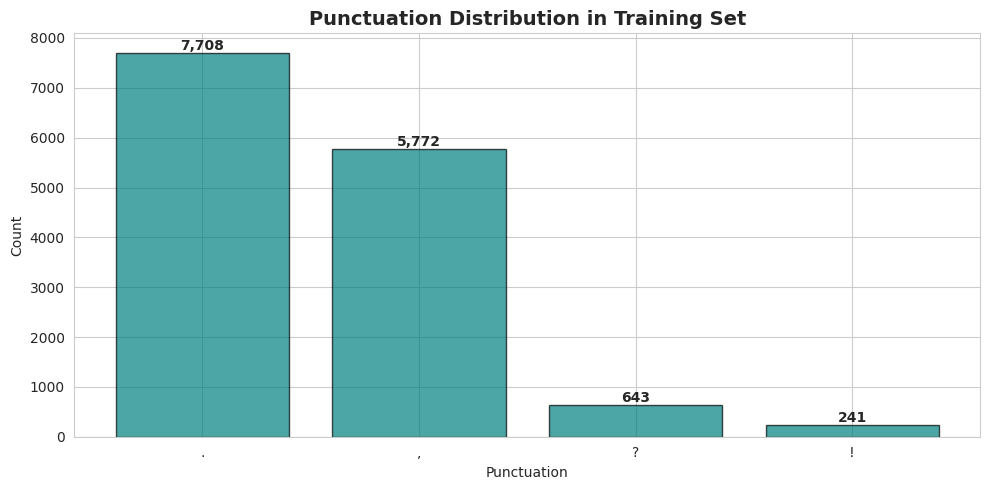


📌 Training Set Punctuation:
  • '.': 7,708 (53.7%)
  • ',': 5,772 (40.2%)
  • '?': 643 (4.5%)
  • '!': 241 (1.7%)


In [8]:
# Split dataset
train_data, val_data = train_test_split(dataset, test_size=0.15, random_state=42)

print(f"📊 Train: {len(train_data):,} sentences")
print(f"📊 Validation: {len(val_data):,} sentences")

# Analyze punctuation distribution in training set
train_punct = {'.': 0, ',': 0, '?': 0, '!': 0}
for item in train_data:
    for p in train_punct.keys():
        train_punct[p] += item['output'].count(p)

plt.figure(figsize=(10, 5))
plt.bar(train_punct.keys(), train_punct.values(), edgecolor='black', alpha=0.7, color='teal')
plt.title('Punctuation Distribution in Training Set', fontsize=14, weight='bold')
plt.xlabel('Punctuation')
plt.ylabel('Count')
for i, (k, v) in enumerate(train_punct.items()):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📌 Training Set Punctuation:")
total = sum(train_punct.values())
for k, v in train_punct.items():
    print(f"  • '{k}': {v:,} ({v/total*100:.1f}%)")

## 8. T5 Seq2Seq Approach

In [9]:
# Initialize T5 model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

print(f"✅ Loaded {model_name}")
print(f"📊 Model parameters: {model.num_parameters():,}")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Loaded t5-small
📊 Model parameters: 60,506,624


In [10]:
# Prepare datasets for T5
def preprocess_function(examples):
    # Add task prefix for T5
    inputs = ["restore punctuation: " + text for text in examples['input']]
    targets = examples['output']

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=128, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Create HuggingFace datasets
train_dataset = Dataset.from_dict({
    'input': [ex['input'] for ex in train_data],
    'output': [ex['output'] for ex in train_data]
})

val_dataset = Dataset.from_dict({
    'input': [ex['input'] for ex in val_data],
    'output': [ex['output'] for ex in val_data]
})

# Tokenize
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

print("✅ Datasets prepared for T5")

Map:   0%|          | 0/6647 [00:00<?, ? examples/s]

Map:   0%|          | 0/1173 [00:00<?, ? examples/s]

✅ Datasets prepared for T5


In [11]:
from collections import defaultdict
from rouge_score import rouge_scorer

def calculate_rouge_scores(predictions, references):

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, ref in zip(predictions, references):

        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

def calculate_hamming_distance(pred_sequence, target_sequence, normalize=True):

    if len(pred_sequence) != len(target_sequence):

        max_len = max(len(pred_sequence), len(target_sequence))
        pred_sequence = pred_sequence.ljust(max_len)[:max_len]
        target_sequence = target_sequence.ljust(max_len)[:max_len]

    hamming_dist = sum(c1 != c2 for c1, c2 in zip(pred_sequence, target_sequence))

    if normalize:
        return hamming_dist / len(pred_sequence) if len(pred_sequence) > 0 else 0
    return hamming_dist

def evaluate_predictions_comprehensive(model, dataset, num_samples=50):

    model.eval()
    device = next(model.parameters()).device

    punct_marks = ['.', ',', '?', '!']


    total_chars = 0
    correct_chars = 0
    total_tokens = 0
    correct_tokens = 0
    exact_matches = 0


    tp = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)


    all_predictions = []
    all_references = []
    hamming_distances = []

    sample_outputs = []

    def normalize_text(text):

        return ' '.join(text.lower().split())

    def extract_punctuation_set(text):

        return set(char for char in text if char in punct_marks)

    for i, example in enumerate(dataset.select(range(min(num_samples, len(dataset))))):
        input_text = "restore punctuation: " + example['input']
        target = normalize_text(example['output'])

        # Generate prediction using beam search for better quality
        inputs = tokenizer(input_text, return_tensors='pt', max_length=128, truncation=True).to(device)
        outputs = model.generate(**inputs, max_length=128, num_beams=2, early_stopping=True)
        prediction = normalize_text(tokenizer.decode(outputs[0], skip_special_tokens=True))

        # Store for ROUGE and Hamming calculation
        all_predictions.append(prediction)
        all_references.append(target)

        # Calculate Hamming distance (normalized)
        hamming_dist = calculate_hamming_distance(prediction, target, normalize=True)
        hamming_distances.append(hamming_dist)

        # Character-level accuracy
        min_len = min(len(target), len(prediction))
        for j in range(min_len):
            total_chars += 1
            if target[j] == prediction[j]:
                correct_chars += 1

        # Exact match (sequence-level accuracy)
        if target == prediction:
            exact_matches += 1

        # Token-level accuracy
        target_tokens = target.split()
        pred_tokens = prediction.split()
        min_tokens = min(len(target_tokens), len(pred_tokens))
        for j in range(min_tokens):
            total_tokens += 1
            if target_tokens[j] == pred_tokens[j]:
                correct_tokens += 1

        # Punctuation-specific metrics using set-based approach
        target_punct = extract_punctuation_set(target)
        pred_punct = extract_punctuation_set(prediction)

        for punct in punct_marks:
            if punct in target_punct and punct in pred_punct:
                tp[punct] += 1  # Correctly predicted
            elif punct in target_punct:
                fn[punct] += 1  # Missed punctuation
            elif punct in pred_punct:
                fp[punct] += 1  # False positive

        # Store samples for qualitative analysis
        if i < 5:
            sample_outputs.append((example['input'], prediction, target))

    # Calculate overall metrics
    char_accuracy = (correct_chars / total_chars * 100) if total_chars > 0 else 0
    token_accuracy = (correct_tokens / total_tokens * 100) if total_tokens > 0 else 0
    exact_match_rate = (exact_matches / num_samples * 100) if num_samples > 0 else 0

    # Calculate per-punctuation metrics
    punct_metrics = {}
    for punct in punct_marks:
        precision = tp[punct] / (tp[punct] + fp[punct]) if (tp[punct] + fp[punct]) > 0 else 0
        recall = tp[punct] / (tp[punct] + fn[punct]) if (tp[punct] + fn[punct]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        punct_metrics[punct] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp[punct],
            'fp': fp[punct],
            'fn': fn[punct]
        }

    # Calculate macro-averaged F1 (average across all punctuation types)
    macro_f1 = np.mean([punct_metrics[p]['f1'] for p in punct_marks])

    # Calculate micro-averaged metrics (pool all TP, FP, FN)
    total_tp = sum(tp.values())
    total_fp = sum(fp.values())
    total_fn = sum(fn.values())
    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    # Calculate ROUGE scores (sequence-level n-gram overlap metrics)
    rouge_scores = calculate_rouge_scores(all_predictions, all_references)

    # Calculate average Hamming distance (lower is better)
    avg_hamming_distance = np.mean(hamming_distances) if hamming_distances else 0
    hamming_accuracy = (1 - avg_hamming_distance) * 100  # Convert distance to accuracy-like metric

    # Print comprehensive results
    print("\n" + "="*70)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*70)

    print(f"\n📊 Overall Metrics:")
    print(f"  • Character-level Accuracy: {char_accuracy:.2f}%")
    print(f"  • Token-level Accuracy:     {token_accuracy:.2f}%")
    print(f"  • Exact Match Rate:         {exact_match_rate:.2f}%")
    print(f"  • Normalized Hamming Distance: {avg_hamming_distance:.4f} (Accuracy: {hamming_accuracy:.2f}%)")

    print(f"\n📊 Sequence-Level Metrics (ROUGE):")
    print(f"  • ROUGE-1 (Unigram overlap):  {rouge_scores['rouge1']:.4f}")
    print(f"  • ROUGE-2 (Bigram overlap):   {rouge_scores['rouge2']:.4f}")
    print(f"  • ROUGE-L (Longest common subsequence): {rouge_scores['rougeL']:.4f}")

    print(f"\n📊 Averaged Performance:")
    print(f"  • Macro-averaged F1:        {macro_f1:.4f}")
    print(f"  • Micro-averaged Precision: {micro_precision:.4f}")
    print(f"  • Micro-averaged Recall:    {micro_recall:.4f}")
    print(f"  • Micro-averaged F1:        {micro_f1:.4f}")

    print(f"\n📊 Per-Punctuation Metrics (Precision / Recall / F1):")
    for punct in punct_marks:
        metrics = punct_metrics[punct]
        print(f"  • '{punct}': "
              f"P={metrics['precision']:.4f}, "
              f"R={metrics['recall']:.4f}, "
              f"F1={metrics['f1']:.4f} "
              f"(TP={metrics['tp']}, FP={metrics['fp']}, FN={metrics['fn']})")

    print("\n📝 Sample Predictions:")
    for inp, pred, tgt in sample_outputs:
        print(f"\n  Input:  {inp}")
        print(f"  Pred:   {pred}")
        print(f"  Target: {tgt}")

    # Return metrics for further analysis
    return {
        'char_accuracy': char_accuracy,
        'token_accuracy': token_accuracy,
        'exact_match_rate': exact_match_rate,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1,
        'rouge_scores': rouge_scores,
        'avg_hamming_distance': avg_hamming_distance,
        'hamming_accuracy': hamming_accuracy,
        'punct_metrics': punct_metrics
    }


def evaluate_predictions(model, dataset, num_samples=50):

    metrics = evaluate_predictions_comprehensive(model, dataset, num_samples)


    correct_punct = {p: metrics['punct_metrics'][p]['tp'] for p in ['.', ',', '?', '!']}
    total_punct = {p: metrics['punct_metrics'][p]['tp'] + metrics['punct_metrics'][p]['fn']
                   for p in ['.', ',', '?', '!']}

    return correct_punct, total_punct


## 9. Baseline Evaluation (Pre-trained T5)

**Evaluating the pre-trained T5 model BEFORE fine-tuning** to establish a baseline performance.
This uses our comprehensive evaluation suite with all metrics: ROUGE, Hamming, F1, Precision, Recall.

In [12]:
# Evaluate baseline (pre-trained T5) using comprehensive metrics
print("🔍 Evaluating BASELINE (pre-trained T5) model...")
print("=" * 70)

# Store baseline metrics for comparison later
baseline_metrics = evaluate_predictions_comprehensive(model, val_dataset, num_samples=100)

# Also get legacy format for backward compatibility
baseline_correct, baseline_total = evaluate_predictions(model, val_dataset, num_samples=100)

🔍 Evaluating BASELINE (pre-trained T5) model...

COMPREHENSIVE EVALUATION RESULTS

📊 Overall Metrics:
  • Character-level Accuracy: 16.99%
  • Token-level Accuracy:     16.59%
  • Exact Match Rate:         3.00%
  • Normalized Hamming Distance: 0.8010 (Accuracy: 19.90%)

📊 Sequence-Level Metrics (ROUGE):
  • ROUGE-1 (Unigram overlap):  0.6479
  • ROUGE-2 (Bigram overlap):   0.6086
  • ROUGE-L (Longest common subsequence): 0.6435

📊 Averaged Performance:
  • Macro-averaged F1:        0.3563
  • Micro-averaged Precision: 0.8795
  • Micro-averaged Recall:    0.4591
  • Micro-averaged F1:        0.6033

📊 Per-Punctuation Metrics (Precision / Recall / F1):
  • '.': P=0.9683, R=0.7093, F1=0.8188 (TP=61, FP=2, FN=25)
  • ',': P=0.5294, R=0.1667, F1=0.2535 (TP=9, FP=8, FN=45)
  • '?': P=1.0000, R=0.2143, F1=0.3529 (TP=3, FP=0, FN=11)
  • '!': P=0.0000, R=0.0000, F1=0.0000 (TP=0, FP=0, FN=5)

📝 Sample Predictions:

  Input:  you catch yourself saying "you aren't worth anything"
  Pred:   sie fa

## 10. Fine-tuning on Mental Health Domain

In [13]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./punctuation_t5",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    predict_with_generate=True,
    logging_steps=100,
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train
print("🚀 Starting fine-tuning...")
trainer.train()
print("✅ Fine-tuning complete!")

🚀 Starting fine-tuning...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: satvik-jain (satvik-jain-siemens) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.023000,0.018073
2,0.018900,0.016590
3,0.015200,0.016604
4,0.012000,0.016736


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


✅ Fine-tuning complete!


## 11. Fine-tuned Model Evaluation

**Evaluating the fine-tuned T5 model AFTER domain-specific training** on mental health conversations.
This uses the same comprehensive evaluation suite to enable direct comparison with baseline.

In [14]:
# Evaluate fine-tuned model using comprehensive metrics
print("🔍 Evaluating FINE-TUNED model...")
print("=" * 70)

# Store fine-tuned metrics for comparison
finetuned_metrics = evaluate_predictions_comprehensive(model, val_dataset, num_samples=100)

# Also get legacy format for backward compatibility
finetuned_correct, finetuned_total = evaluate_predictions(model, val_dataset, num_samples=100)

🔍 Evaluating FINE-TUNED model...

COMPREHENSIVE EVALUATION RESULTS

📊 Overall Metrics:
  • Character-level Accuracy: 68.48%
  • Token-level Accuracy:     96.32%
  • Exact Match Rate:         55.00%
  • Normalized Hamming Distance: 0.2115 (Accuracy: 78.85%)

📊 Sequence-Level Metrics (ROUGE):
  • ROUGE-1 (Unigram overlap):  0.9998
  • ROUGE-2 (Bigram overlap):   0.9997
  • ROUGE-L (Longest common subsequence): 0.9998

📊 Averaged Performance:
  • Macro-averaged F1:        0.6724
  • Micro-averaged Precision: 0.9272
  • Micro-averaged Recall:    0.8805
  • Micro-averaged F1:        0.9032

📊 Per-Punctuation Metrics (Precision / Recall / F1):
  • '.': P=0.9348, R=1.0000, F1=0.9663 (TP=86, FP=6, FN=0)
  • ',': P=0.8958, R=0.7963, F1=0.8431 (TP=43, FP=5, FN=11)
  • '?': P=1.0000, R=0.7857, F1=0.8800 (TP=11, FP=0, FN=3)
  • '!': P=0.0000, R=0.0000, F1=0.0000 (TP=0, FP=0, FN=5)

📝 Sample Predictions:

  Input:  you catch yourself saying "you aren't worth anything"
  Pred:   you catch yourself s

## 12. Comprehensive Model Comparison

**Comparing baseline vs fine-tuned model across ALL metrics:**
- Character/Token/Exact Match Accuracy
- ROUGE-1, ROUGE-2, ROUGE-L scores
- Hamming Distance (sequence similarity)
- Macro/Micro F1, Precision, Recall
- Per-punctuation performance (. , ? !)

In [15]:
# Comprehensive comparison of baseline vs fine-tuned models
print("=" * 70)
print("📊 COMPREHENSIVE MODEL COMPARISON: BASELINE vs FINE-TUNED")
print("=" * 70)

# Create comparison dataframe for all metrics
comparison_data = {
    'Metric': [
        'Character Accuracy (%)',
        'Token Accuracy (%)',
        'Exact Match Rate (%)',
        'Hamming Accuracy (%)',
        'ROUGE-1',
        'ROUGE-2',
        'ROUGE-L',
        'Macro F1',
        'Micro F1',
        'Micro Precision',
        'Micro Recall'
    ],
    'Baseline': [
        baseline_metrics['char_accuracy'],
        baseline_metrics['token_accuracy'],
        baseline_metrics['exact_match_rate'],
        baseline_metrics['hamming_accuracy'],
        baseline_metrics['rouge_scores']['rouge1'],
        baseline_metrics['rouge_scores']['rouge2'],
        baseline_metrics['rouge_scores']['rougeL'],
        baseline_metrics['macro_f1'],
        baseline_metrics['micro_f1'],
        baseline_metrics['micro_precision'],
        baseline_metrics['micro_recall']
    ],
    'Fine-tuned': [
        finetuned_metrics['char_accuracy'],
        finetuned_metrics['token_accuracy'],
        finetuned_metrics['exact_match_rate'],
        finetuned_metrics['hamming_accuracy'],
        finetuned_metrics['rouge_scores']['rouge1'],
        finetuned_metrics['rouge_scores']['rouge2'],
        finetuned_metrics['rouge_scores']['rougeL'],
        finetuned_metrics['macro_f1'],
        finetuned_metrics['micro_f1'],
        finetuned_metrics['micro_precision'],
        finetuned_metrics['micro_recall']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement'] = comparison_df['Fine-tuned'] - comparison_df['Baseline']
comparison_df['% Change'] = ((comparison_df['Fine-tuned'] - comparison_df['Baseline']) /
                              comparison_df['Baseline'].replace(0, 1) * 100)

print("\n📈 Overall Metrics Comparison:")
print(comparison_df.to_string(index=False))

# Per-punctuation comparison
print("\n" + "=" * 70)
print("📌 PER-PUNCTUATION F1 SCORE COMPARISON")
print("=" * 70)

punct_marks = ['.', ',', '?', '!']
punct_comparison = []
for p in punct_marks:
    base_f1 = baseline_metrics['punct_metrics'][p]['f1']
    fine_f1 = finetuned_metrics['punct_metrics'][p]['f1']
    improvement = fine_f1 - base_f1
    punct_comparison.append({
        'Punctuation': f"'{p}'",
        'Baseline F1': f"{base_f1:.4f}",
        'Fine-tuned F1': f"{fine_f1:.4f}",
        'Improvement': f"{improvement:+.4f}"
    })

punct_df = pd.DataFrame(punct_comparison)
print(punct_df.to_string(index=False))

📊 COMPREHENSIVE MODEL COMPARISON: BASELINE vs FINE-TUNED

📈 Overall Metrics Comparison:
                Metric  Baseline  Fine-tuned  Improvement    % Change
Character Accuracy (%) 16.992298   68.480796    51.488499  303.010810
    Token Accuracy (%) 16.588664   96.320346    79.731683  480.639580
  Exact Match Rate (%)  3.000000   55.000000    52.000000 1733.333333
  Hamming Accuracy (%) 19.900150   78.853626    58.953475  296.246385
               ROUGE-1  0.647869    0.999816     0.351947   54.323815
               ROUGE-2  0.608583    0.999722     0.391139   64.270520
               ROUGE-L  0.643459    0.999816     0.356357   55.381376
              Macro F1  0.356314    0.672357     0.316044   88.698219
              Micro F1  0.603306    0.903226     0.299920   49.712771
       Micro Precision  0.879518    0.927152     0.047634    5.415948
          Micro Recall  0.459119    0.880503     0.421384   91.780822

📌 PER-PUNCTUATION F1 SCORE COMPARISON
Punctuation Baseline F1 Fine-tune

## 13. Save Fine-tuned Model

Save the trained model and tokenizer for future use and deployment.

In [18]:
# Save the final fine-tuned model and tokenizer
import shutil
import os

print("💾 Saving final fine-tuned model and tokenizer...")

final_model_path = "./punctuation_t5/final_model"
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"✅ Final model saved to: {final_model_path}")

# For Google Colab: Download model as zip file
try:
    from google.colab import files

    # Create a clean directory with just the final model
    download_dir = "punctuation_t5_final_model"
    if os.path.exists(download_dir):
        shutil.rmtree(download_dir)
    os.makedirs(download_dir)

    # Copy model and tokenizer files
    if os.path.exists(final_model_path):
        shutil.copytree(final_model_path, download_dir, dirs_exist_ok=True)

        # Create zip archive
        zip_filename = "punctuation_t5_finetuned_model.zip"
        if os.path.exists(zip_filename):
            os.remove(zip_filename)

        shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', download_dir)

        print(f"📦 Model packaged: {zip_filename}")
        files.download(zip_filename)
        print("✅ Model download initiated!")
except ImportError:
    print("📁 Running locally - model saved to:", final_model_path)

💾 Saving final fine-tuned model and tokenizer...
✅ Final model saved to: ./punctuation_t5/final_model
📦 Model packaged: punctuation_t5_finetuned_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model download initiated!


## 14. Testing

Test the fine-tuned model with custom input sentences to see punctuation restoration in action.

In [19]:
def restore_punctuation(text, model, tokenizer):
    model.eval()
    device = next(model.parameters()).device

    input_text = "restore punctuation: " + text.lower()
    inputs = tokenizer(input_text, return_tensors='pt', max_length=128, truncation=True).to(device)
    outputs = model.generate(**inputs, max_length=128)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return result

# Test samples
test_texts = [
    "i think you should talk to your therapist about this",
    "how are you feeling today",
    "its important to take care of your mental health",
    "have you tried meditation or mindfulness exercises",
    "anxiety is a normal response but it can be overwhelming"
]

print("\n" + "="*70)
print("INTERACTIVE TESTING")
print("="*70)

for text in test_texts:
    result = restore_punctuation(text, model, tokenizer)
    print(f"\n📝 Input:  {text}")
    print(f"✅ Output: {result}")


INTERACTIVE TESTING

📝 Input:  i think you should talk to your therapist about this
✅ Output: i think you should talk to your therapist about this.

📝 Input:  how are you feeling today
✅ Output: how are you feeling today?

📝 Input:  its important to take care of your mental health
✅ Output: its important to take care of your mental health.

📝 Input:  have you tried meditation or mindfulness exercises
✅ Output: have you tried meditation or mindfulness exercises?

📝 Input:  anxiety is a normal response but it can be overwhelming
✅ Output: anxiety is a normal response, but it can be overwhelming.
